In [1]:
import pandas as pd
import numpy as np
import itertools
import igraph
import sys
import collections
import datetime
import random

In [2]:
G = igraph.Graph.Read_GraphML(f = 'networks/EM-TE-16.graphml')

In [13]:
period = 'raw_em'

In [14]:
od_data = pd.read_csv('TTS OD/LICO_TTS.csv')
od_data['origin'] = od_data['origin'] + 1000
od_data['destination'] = od_data['destination'] + 1000
od_data

,origin,destination,type,total
0,1001,1018,raw_am,15
1,1001,1035,raw_am,14
2,1001,1057,raw_am,20
3,1001,1068,raw_am,14
4,1001,1212,raw_am,8
...,...,...,...,...
30463,1603,1223,c0_ev,8
30464,1610,1561,c0_ev,22
30465,1613,1523,c0_ev,21
30466,1613,1578,c0_ev,47


In [24]:
bc_weighted = pd.read_csv('BC Results Notebooks/bc_weighted_node.csv')
bc_weighted = bc_weighted[bc_weighted['type'] == period].sort_values(by = 'weighted', ascending = False
                                                                    ).reset_index().drop(columns = 'index')
bc_weighted

,INT_ID,weighted,type
0,106,2.705856e-08,raw_em
1,210,1.822766e-08,raw_em
2,156,1.638376e-08,raw_em
3,215,1.620045e-08,raw_em
4,216,1.532694e-08,raw_em
...,...,...,...
2186,20110447,1.614793e-13,raw_em
2187,13469498,1.614793e-13,raw_em
2188,13469402,1.614793e-13,raw_em
2189,13468530,1.076528e-13,raw_em


In [6]:
depart_hour = '-4-'
rand_time = []

for i in range(6):
    minute = random.randint(0,9)
    minute = minute + i*10
    rand_time.append(depart_hour + str(minute))

In [7]:
node_key_table = []

for i in G.vs:
    node_key_table.append([i.index,  i['id']])
node_df = pd.DataFrame.from_records(node_key_table, columns = ['index', 'node_id'])

In [8]:
node_df['INT_ID'] = node_df['node_id'].str.split('-', expand = True)[0]
node_df['node_time'] = node_df['node_id'].str.split('-', expand = True)[0] + '-' + node_df['node_id'].str.split('-', expand = True)[2] + '-' + node_df['node_id'].str.split('-', expand = True)[3]
node_dict = node_df[['INT_ID']].to_dict()['INT_ID']
time_dict = node_df[['node_time']].to_dict()['node_time']
node_df

,index,node_id,INT_ID,node_time
0,0,13464667-0-4-0,13464667,13464667-4-0
1,1,13464667-0-4-1,13464667,13464667-4-1
2,2,13464667-0-4-2,13464667,13464667-4-2
3,3,13464667-0-4-3,13464667,13464667-4-3
4,4,13464667-0-4-4,13464667,13464667-4-4
...,...,...,...,...
1472384,1472384,13452625-0-8-55,13452625,13452625-8-55
1472385,1472385,13452625-0-8-56,13452625,13452625-8-56
1472386,1472386,13452625-0-8-57,13452625,13452625-8-57
1472387,1472387,13452625-0-8-58,13452625,13452625-8-58


In [15]:
node_data = od_data[od_data['type'] == period][['origin', 'destination']].copy()
node_data['origin'] = node_data['origin'].astype(str)
node_data['destination'] = node_data['destination'].astype(str)

#node_data['o_node'] = node_data['origin'] + '-0' + rand_time[5]
#for limit testing
node_data['o_node'] = node_data['origin'] + '-0-4-59'

node_data['d_node'] = node_data['destination'] + '-0-99-99'
node_data = node_data.reset_index()
node_data

,index,origin,destination,o_node,d_node
0,226,1018,1034,1018-0-4-59,1034-0-99-99
1,462,1021,1361,1021-0-4-59,1361-0-99-99
2,465,1021,1386,1021-0-4-59,1386-0-99-99
3,502,1021,1519,1021-0-4-59,1519-0-99-99
4,509,1021,1545,1021-0-4-59,1545-0-99-99
...,...,...,...,...,...
171,23621,1606,1068,1606-0-4-59,1068-0-99-99
172,23636,1606,1415,1606-0-4-59,1415-0-99-99
173,23822,1619,1056,1619-0-4-59,1056-0-99-99
174,23855,1620,1220,1620-0-4-59,1220-0-99-99


In [16]:
o_list = list(node_df[node_df['node_id'].isin(node_data['o_node'])]['index'])
d_list = list(node_df[node_df['node_id'].isin(node_data['d_node'])]['index'])

In [17]:
%%time

out_all = G.shortest_paths(o_list, d_list, weights = 'cost',  mode = 'out')

Wall time: 10 s


In [43]:
table = []
for i in range(len(o_list)):
    temp_lst = out_all[i]
    for j in range(len(d_list)):
        table.append([o_list[i], d_list[j], temp_lst[j], 0])
        

In [44]:
importance_df = pd.DataFrame.from_records(table, columns = ['index_o', 'index_d', 'travel_time', 'iteration'])
importance_df = importance_df.merge(node_df[['node_id', 'index']], left_on = ['index_o'], right_on = ['index'])
importance_df = importance_df.rename(columns = {'node_id':'o_node'})[['o_node', 'index_d', 'travel_time', 'iteration']]
importance_df = importance_df.merge(node_df[['node_id', 'index']], left_on = ['index_d'], right_on = ['index'])
importance_df = importance_df.rename(columns = {'node_id':'d_node'})[['o_node', 'd_node', 'travel_time', 'iteration']]
importance_df = importance_df.merge(node_data[['o_node', 'd_node']])

In [45]:
G_copy = G.copy()

In [55]:
%%time

G_copy = G.copy()

node_df_new = node_df

iteration = 0
for index, row in bc_weighted.iterrows():

    node_key_table = []

    for i in G_copy.vs:
        node_key_table.append([i.index,  i['id']])
    node_df_new = pd.DataFrame.from_records(node_key_table, columns = ['index', 'node_id'])

    node_df_new['INT_ID'] = node_df_new['node_id'].str.split('-', expand = True)[0]

    o_list_new = list(node_df_new[node_df_new['node_id'].isin(node_data['o_node'])]['index'])
    d_list_new = list(node_df_new[node_df_new['node_id'].isin(node_data['d_node'])]['index'])
    
    out_all = G_copy.shortest_paths(o_list_new, d_list_new, weights = 'cost',  mode = 'out')
    table = []
    for i in range(len(o_list_new)):
        temp_lst = out_all[i]
        for j in range(len(d_list_new)):
            table.append([o_list_new[i], d_list_new[j], temp_lst[j], iteration])
            
    temp_df = pd.DataFrame.from_records(table, columns = ['index_o', 'index_d', 'travel_time', 'iteration'])
    temp_df = temp_df.merge(node_df_new[['node_id', 'index']], left_on = ['index_o'], right_on = ['index'])
    temp_df = temp_df.rename(columns = {'node_id':'o_node'})[['o_node', 'index_d', 'travel_time', 'iteration']]
    temp_df = temp_df.merge(node_df_new[['node_id', 'index']], left_on = ['index_d'], right_on = ['index'])
    temp_df = temp_df.rename(columns = {'node_id':'d_node'})[['o_node', 'd_node', 'travel_time', 'iteration']]
    temp_df = temp_df.merge(node_data[['o_node', 'd_node']])
    
    if iteration == 0:
        importance_df = temp_df.copy()
    else:
        importance_df = importance_df.append(temp_df)
    iteration = iteration + 1
    
        
    del_node = row['INT_ID']

    del_list = list(node_df_new[node_df_new['INT_ID'] == str(del_node)]['index'])
    G_copy.delete_vertices(del_list)

    
    
    if iteration%10 == 0:
        print(iteration, G_copy.vcount(), G_copy.ecount())
    
    if iteration == 25:
        break

10 1466945 14994619
20 1462223 14919059
Wall time: 9min 59s


<AxesSubplot:xlabel='iteration'>

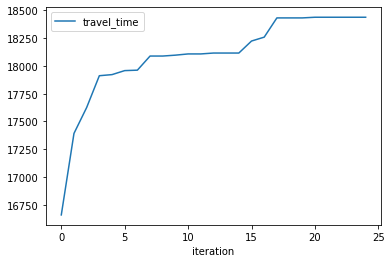

In [56]:
importance_df.groupby('iteration').sum().plot()

In [57]:
importance_df.groupby('iteration').sum()

,travel_time
iteration,
0,16659.0
1,17392.0
2,17625.0
3,17911.0
4,17921.0
5,17957.0
6,17961.0
7,18088.0
8,18088.0


# Individual Iterations

In [134]:
G_copy = G.copy()

In [135]:
G_copy.vcount(), G_copy.ecount()

(1787250, 15402561)

In [136]:
#del_list = list(node_df[node_df['INT_ID'] == str(bc_weighted.loc[0,'INT_ID'])]['index'])


In [137]:
#del_list = list(node_df[node_df['INT_ID'] == str(bc_weighted.loc[0,'INT_ID'])]['index'])

str_del = [str(i)  for  i  in list(bc_weighted.head(100)['INT_ID'])]

del_list = list(node_df[node_df['INT_ID'].isin(str_del)]['index'])

In [138]:
G_copy.delete_vertices(del_list)

In [139]:
# G_copy.delete_vertices(19800)

In [140]:
node_key_table = []

for i in G_copy.vs:
    node_key_table.append([i.index,  i['id']])
node_df_new = pd.DataFrame.from_records(node_key_table, columns = ['index', 'node_id'])

node_df_new['INT_ID'] = node_df_new['node_id'].str.split('-', expand = True)[0]

o_list_new = list(node_df_new[node_df_new['node_id'].isin(node_data['o_node'])]['index'])
d_list_new = list(node_df_new[node_df_new['node_id'].isin(node_data['d_node'])]['index'])

In [141]:
G_copy.vcount(), G_copy.ecount()

(1717839, 14340489)

In [142]:
out_all = G_copy.shortest_paths(o_list_new, d_list_new, weights = 'cost',  mode = 'out')
table = []
for i in range(len(o_list_new)):
    temp_lst = out_all[i]
    for j in range(len(d_list_new)):
        table.append([o_list_new[i], d_list_new[j], temp_lst[j], 1])
temp_df = pd.DataFrame.from_records(table, columns = ['index_o', 'index_d', 'travel_time', 'iteration'])
temp_df = temp_df.merge(node_df_new[['node_id', 'index']], left_on = ['index_o'], right_on = ['index'])
temp_df = temp_df.rename(columns = {'node_id':'o_node'})[['o_node', 'index_d', 'travel_time', 'iteration']]
temp_df = temp_df.merge(node_df_new[['node_id', 'index']], left_on = ['index_d'], right_on = ['index'])
temp_df = temp_df.rename(columns = {'node_id':'d_node'})[['o_node', 'd_node', 'travel_time', 'iteration']]
temp_df = temp_df.merge(node_data[['o_node', 'd_node']])

In [143]:
temp_df[temp_df['travel_time'] ==np.inf]

,o_node,d_node,travel_time,iteration
36,1336-0-7-59,1016-0-99-99,inf,1
298,1129-0-7-59,1029-0-99-99,inf,1
299,1145-0-7-59,1029-0-99-99,inf,1
300,1154-0-7-59,1029-0-99-99,inf,1
309,1321-0-7-59,1029-0-99-99,inf,1
310,1322-0-7-59,1029-0-99-99,inf,1
311,1335-0-7-59,1029-0-99-99,inf,1
312,1342-0-7-59,1029-0-99-99,inf,1


In [146]:
temp_df.sort_values(by = 'travel_time', ascending = False).head(20)

,o_node,d_node,travel_time,iteration
299,1145-0-7-59,1029-0-99-99,inf,1
312,1342-0-7-59,1029-0-99-99,inf,1
310,1322-0-7-59,1029-0-99-99,inf,1
309,1321-0-7-59,1029-0-99-99,inf,1
36,1336-0-7-59,1016-0-99-99,inf,1
300,1154-0-7-59,1029-0-99-99,inf,1
311,1335-0-7-59,1029-0-99-99,inf,1
298,1129-0-7-59,1029-0-99-99,inf,1
4280,1570-0-7-59,1290-0-99-99,253.0,1
4220,1575-0-7-59,1285-0-99-99,250.0,1


In [147]:
temp_df

,o_node,d_node,travel_time,iteration
0,1250-0-7-59,1001-0-99-99,44.0,1
1,1540-0-7-59,1001-0-99-99,29.0,1
2,1211-0-7-59,1003-0-99-99,63.0,1
3,1534-0-7-59,1003-0-99-99,69.0,1
4,1105-0-7-59,1004-0-99-99,100.0,1
...,...,...,...,...
5989,1397-0-7-59,1007-0-99-99,249.0,1
5990,1100-0-7-59,1081-0-99-99,52.0,1
5991,1211-0-7-59,1081-0-99-99,61.0,1
5992,1423-0-7-59,1081-0-99-99,201.0,1


In [172]:
temp_df['status'] = True

In [175]:
check_diff = importance_df.merge(temp_df[['o_node', 'd_node', 'status']], how = 'left')
check_diff[check_diff['status'] != True]

,o_node,d_node,travel_time,iteration,status
75,1065-0-7-59,1021-0-99-99,37.0,0,NaN
180,1065-0-7-59,1025-0-99-99,21.0,0,NaN
429,1054-0-7-59,1036-0-99-99,9.0,0,NaN
649,1021-0-7-59,1038-0-99-99,20.0,0,NaN
650,1041-0-7-59,1038-0-99-99,16.0,0,NaN
...,...,...,...,...,...
7182,1038-0-7-59,1559-0-99-99,69.0,0,NaN
7183,1052-0-7-59,1559-0-99-99,69.0,0,NaN
7339,1054-0-7-59,1593-0-99-99,77.0,0,NaN
7340,1055-0-7-59,1594-0-99-99,79.0,0,NaN


In [181]:
node_df_new[node_df_new['node_id'] == '1038-0-99-99']

,index,node_id,INT_ID


In [182]:
importance_df.sort_values(by = 'travel_time', ascending = False).head(20)

,o_node,d_node,travel_time,iteration
6075,1624-0-7-59,1371-0-99-99,147.0,0
7451,1397-0-7-59,1007-0-99-99,136.0,0
6111,1613-0-7-59,1388-0-99-99,130.0,0
7444,1338-0-7-59,1616-0-99-99,129.0,0
5722,1570-0-7-59,1290-0-99-99,128.0,0
5723,1590-0-7-59,1290-0-99-99,128.0,0
6073,1555-0-7-59,1371-0-99-99,127.0,0
6211,1559-0-7-59,1391-0-99-99,127.0,0
6074,1579-0-7-59,1371-0-99-99,126.0,0
5917,1585-0-7-59,1335-0-99-99,124.0,0
